# Useful articles

- [Dealing with categorical features](https://medium.com/hugo-ferreiras-blog/dealing-with-categorical-features-in-machine-learning-1bb70f07262d)

- ['statsmodels' library](https://www.statsmodels.org/stable/index.html)

- [some potentially useful packages](https://medium.com/activewizards-machine-learning-company/top-15-python-libraries-for-data-science-in-in-2017-ab61b4f9b4a7)

- [other pot. useful packages](https://www.kdnuggets.com/2018/06/top-20-python-libraries-data-science-2018.html/2)

- ['seaborn' library (visualization)](https://seaborn.pydata.org/tutorial.html)

- [Nyttig eksempel](https://becominghuman.ai/linear-regression-in-python-with-pandas-scikit-learn-72574a2ec1a5)

- [Eksempel med gradient boost regression på boston housing](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py)

# Small tasks yet to be done

Yohann
- Legge inn skrivefeil-fiksing
- Forklare hvorfor vi logtransformerer SalePrice
- Skrive litt om hvorfor vi vurderer så mange ulike modeller, og kort forklaring på hvorfor de scorer som de gjør

Eivind
- Bytte på akser i performance plots (actual vs predicted)
- Sammenligne GBR, XGB eller begge før, og etter HP optimalisering
- Legge til bildetekst på performance plots med RMSE og legends (pluss endre farge, linje grønn prikker røde)
- Legge inn alle referanser vi kommer på (sckitlearn for learning curve)
- subplot med xgb etter preliminary results
- Konklusjon
- Innledning
- Vedlegg
- Sammendrag
- Innholdsfortegnelse
- Lese over

### Declaring libraries

In [20]:
%matplotlib inline
# For configuration and jupiter
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation and processing
import pandas as pd
import numpy as np
from scipy import stats
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For performance evaluation
from time import time
from tqdm import tqdm

os.environ["OPENBLAS_NUM_THREADS"] = "1"   # Required by implicit
base = "/mnt/workspace/AML-2019/Challenges/House_Pricing/challenge_data/"
# Display
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Data exploration
### Fetching data

In [21]:
#pricesRawDF = pd.read_csv(base + 'train.csv', keep_default_na = False)
pricesRawDF = pd.read_csv(base + 'train.csv')
null_values = pricesRawDF.isnull().sum().sort_values(ascending = False)
null_values[:20]
#print(null_values.index)

PoolQC          1196
MiscFeature     1153
Alley           1125
Fence            973
FireplaceQu      564
LotFrontage      210
GarageType        67
GarageCond        67
GarageYrBlt       67
GarageFinish      67
GarageQual        67
BsmtExposure      33
BsmtFinType2      33
BsmtFinType1      32
BsmtCond          32
BsmtQual          32
MasVnrArea         6
MasVnrType         6
Exterior2nd        0
Exterior1st        0
dtype: int64

Notably many values missing in many of the columns. In the case all the categories this is because the category "NA" has been interpreted as NaN by the "read_csv" function. So first we correct for this. 

In [22]:
columns_with_NaN = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
       'GarageType', 'GarageCond', 'GarageFinish', 'GarageQual',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
       'MasVnrType']
for col in columns_with_NaN:
    pricesRawDF[col] = pricesRawDF[col].fillna('NA')

pricesRawDF['MasVnrArea'] = pricesRawDF['MasVnrArea'].fillna(0)
pricesRawDF['LotFrontage'] = pricesRawDF['LotFrontage'].fillna(0)
pricesRawDF['GarageYrBlt'] = pricesRawDF['GarageYrBlt'].fillna(0)

pricesRawDF.isnull().sum().any()

False

## Reformatting data
In a statistical model or machine learning model, it is much easier to use numerical data rather than categorical data. For categorical columns, we can either make them numerical directly or split them into individual boolean columns by one-hot encoding. Of the categorical columns in the dataset, we have chosen to one-hot encode som columns and make some numerical. First let us check if all the possible categories that a column can take, are represented in the data we have.

In [23]:
# To check if number of unique elements in coloumn exceeds number of types in data description
# Only useful for columns with categorical data 
nr_column_categories = []

for column in pricesRawDF:
    nr_column_categories.append((column, pricesRawDF[column].nunique()))

for elements in nr_column_categories[:10]:
    print(elements)

('Id', 1200)
('MSSubClass', 15)
('MSZoning', 5)
('LotFrontage', 107)
('LotArea', 913)
('Street', 2)
('Alley', 3)
('LotShape', 4)
('LandContour', 4)
('Utilities', 2)


After inspecting "Data Description.rtf" we can see that some of the columns containing categorical data do not contain all the possible categories. For example an element of the column "MSSubClass" can take 16 unique values but only 15 are represented. This means that transforming the values in categorical columns to numerical values, or one-hot-encoding will be a bit cumbersome. 

In [24]:
# Transforming the categories we want to be numeric, to numeric values
from variables import cats_split, cats_num

# The categories we want to split
categorical_to_split = ['MSSubClass', 'MSZoning', 'Alley', 'LotConfig', 'Utilities',
                       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                       'Foundation', 'Heating', 'Electrical', 'GarageType', 'PavedDrive', 
                       'MiscFeature', 'SaleType', 'SaleCondition']

# Casting the type of all columns we want to one-hot-key to strings
for cat in categorical_to_split:
    pricesRawDF[cat] = pricesRawDF[cat].astype(str, errors = 'ignore')

# Categories to make numerical
categorical_to_make_numerical = ['Street', 'LotShape', 'LandContour', 'LandSlope', 'CentralAir',
                                'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                                'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
                                'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond',
                                'PoolQC', 'Fence']
# Cast remaining columns to int64
remaining_columns = [name for name in pricesRawDF.columns if name not in (categorical_to_split + categorical_to_make_numerical)]
for column in remaining_columns:
    pricesRawDF[column] = pricesRawDF[column].astype(np.float64, errors = 'ignore')

# Function to make desired columns numerical
def numerize(rawDF, complete_mapping_dictionary):
    DF = rawDF.copy()
    errors = []
    for mapping_dictionary in complete_mapping_dictionary:
        # Fetching column name
        col_name = mapping_dictionary['name']
        # Fetching column
        column_to_numerize = DF[col_name].copy()
        # Creating columns of same size, and correct type
        numerized_column = pd.Series(np.zeros([column_to_numerize.size]), dtype=np.int8, name=col_name)
        # Resetting error_counter
        error_counter = 0
        # Looping through elements of column
        for index, value in column_to_numerize.iteritems():
            if (value in mapping_dictionary):
                numerized_column.at[index] = mapping_dictionary[value]
            else:
                error_counter += 1
        # Merging numerized column into dataframe
        DF.drop(labels=col_name, axis=1, inplace=True)
        DF[col_name] = numerized_column
        # Appending errors to error vector
        errors.append((col_name, error_counter))
    return errors, DF

# Function for one-hot-encoding a single column, given the column and its possible categories
def split_and_filter(col_name, DF, categories):
    # Extracting column to split
    column_to_split = DF[col_name].copy()
    # Setting new names for columns
    new_col_names = [(col_name + '_' + category) for category in categories]
    # Creating expanded DF of zeros
    splitDF = pd.DataFrame(np.zeros([column_to_split.size,len(categories)], dtype = np.int8), columns = categories)
    # Resetting error_counter
    error_counter = 0
    # Looping through series and setting correct values in new DF
    for index, value in column_to_split.iteritems():
        # Checking if the value is valid, i.e exists in the set of possible categories for one column
        if (value in categories):
            splitDF.at[index, value] = 1
        else:
            error_counter += 1
    # Renaming columns of new dataframe
    splitDF.columns = new_col_names
    # Merging expansion of one column with full DataFrame
    newDF = pd.merge(DF, splitDF, left_index=True, right_index=True)
    # Dropping original column
    newDF.drop([col_name], axis=1, inplace=True)
    # Deleting unused dataframe and series to conserve memory
    del splitDF
    del column_to_split
    return error_counter, newDF

# Function to one-hot encode the entire dataframe given a dataframe and list of names for new columns
def category_splitting(rawDF, list_of_categories):
    first_err, newDF = split_and_filter(list_of_categories[0][0], rawDF, list_of_categories[0][1:])
    errors = [(list_of_categories[0][0], first_err)]
    for column_to_split in list_of_categories[1:]:
        nth_err, newDF = split_and_filter(column_to_split[0], newDF, column_to_split[1:])
        errors.append((column_to_split[0], nth_err))
    return errors, newDF

# Function to reformat a dataset to our desired format
def reformat_dataset(rawDF):
    num_errors, numerizedDF = numerize(rawDF, cats_num)
    split_errors, reformattedDF = category_splitting(numerizedDF, cats_split)
    errors = num_errors + split_errors
    return errors, reformattedDF

errors, rfmtDF = reformat_dataset(pricesRawDF)

# Pre-processing 
## Error processing
Apart from missing values, we found some errors when reformatting the categorical columns. Now let as look at what errors we have got.

In [25]:
for columns in errors:
    if(columns[1] > 0):
        print(columns)

('BldgType', 106)
('Exterior2nd', 85)
('MasVnrType', 6)


Here we can see that we have some errors. How we have classified "errors" in this sense, is that there has been an cell that did not contain one of the predefined elements in the "Data description" file. Now we inspect the values that give errors.

In [26]:
from variables import error_detect # This is a dictionary with the columns where we have found errors. 

error_values = []
for defect_col_name in error_detect:
    err = []
    defect_col = pricesRawDF[defect_col_name[0]]
    categories = defect_col_name[1:]
    for index, value in defect_col.iteritems():
        if value not in categories:
            err.append(value)
    error_values.append(set(err))

for index in range(len(error_values)):
    print('Errors in', error_detect[index][0])
    print(error_values[index])

Errors in BldgType
{'2fmCon', 'Twnhs', 'Duplex'}
Errors in Exterior2nd
{'Brk Cmn', 'Wd Shng', 'CmentBd'}
Errors in MasVnrType
{'NA'}


Now we can see that the errors are due to the following reasons:
    
* BldgType:  
 * Spelling error: "2fmCon" instead of "2FmCon"
 * Spelling error: "Duplex" instead of "Duplx"
 * Spelling error: Many elements have been spelled as "Twnhs". the problem now is that it is impossible to discern whether they have ment the category "TwnhsI" or "TwnhsE"
 * Correcting function (that fixes spelling errors and combines the two "Twnhs" categories to one)
* Exterior2nd:  
 * Spelling error: "Wd Shng" instead of "Wd Sdng"
 * Spelling error: "CmentBd" instead of "CemntBd"
 * Spelling error: "Brk Cmn" instead of "BrkComm"
 * Correcting function
* MasVnrType:  
 * Six elements where this category is not applicable
 * No correction is required, these values can remain zero.

In [27]:
# Spelling-error-correcting function
def correct_known_spelling_errors(rawDF, reformattedDF):
    toReturnDF = reformattedDF.copy()
    cols_to_correct = ['BldgType', 'Exterior2nd']
    error_fix_count = 0
    ################## BldgType
    col = rawDF['BldgType']
    for index, value in col.iteritems():
        if value == '2fmCon':
            toReturnDF.at[index, 'BldgType_2FmCon'] = 1
            error_fix_count += 1
        elif value == 'Duplex':
            toReturnDF.at[index, 'BldgType_Duplx'] = 1
            error_fix_count += 1
     ################## Exterior2nd
    col = rawDF['Exterior2nd']
    for index, value in col.iteritems():
        if value == 'Wd Shng':
            toReturnDF.at[index, 'Exterior2nd_Wd Sdng'] = 1
            error_fix_count += 1
        elif value == 'CmentBd':
            toReturnDF.at[index, 'Exterior2nd_CemntBd'] = 1
            error_fix_count += 1
        elif value == 'Brk Cmn':
            toReturnDF.at[index, 'Exterior2nd_BrkComm'] = 1
            error_fix_count += 1
    print('Nr. of errors corrected: ', error_fix_count)
    return toReturnDF

rfmtDF = correct_known_spelling_errors(pricesRawDF, rfmtDF)

Nr. of errors corrected:  154


In [28]:
# Function to compensate for "Twnhs" spelling erorr
def twnhs_combiner(rawDF, reformattedDF):
    toReturnDF = reformattedDF.copy()
    error_fix_count = 0
    toReturnDF['BldgType_Twnhs'] = toReturnDF['BldgType_TwnhsI'] + toReturnDF['BldgType_TwnhsE']
    toReturnDF.drop(['BldgType_TwnhsI', 'BldgType_TwnhsE'], axis=1, inplace=True)
    BldgType_col = rawDF['BldgType']
    for index, value in BldgType_col.iteritems():
        if value == 'Twnhs':
            toReturnDF.at[index, 'BldgType_Twnhs'] = 1 
            error_fix_count += 1
    print('Nr. of errors corrected: ', error_fix_count)
    return toReturnDF

correctedDF = twnhs_combiner(pricesRawDF, rfmtDF)

Nr. of errors corrected:  37


## Error processing on test-data


In [29]:
testDataRawDF = pd.read_csv(base + 'test.csv')
null_values = testDataRawDF.isnull().sum().sort_values(ascending = False)
null_values[:20]

PoolQC          257
MiscFeature     253
Alley           244
Fence           206
FireplaceQu     126
LotFrontage      49
GarageCond       14
GarageType       14
GarageYrBlt      14
GarageFinish     14
GarageQual       14
BsmtExposure      5
BsmtCond          5
BsmtQual          5
BsmtFinType1      5
BsmtFinType2      5
MasVnrArea        2
MasVnrType        2
Electrical        1
LotConfig         0
dtype: int64

Here we have all the same errors as before, with the exception of one "NA" in Electrical. But, this can be treated as the others

In [30]:
columns_with_NaN = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
       'GarageType', 'GarageCond', 'GarageFinish', 'GarageQual',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
       'MasVnrType', 'Electrical']
for col in columns_with_NaN:
    testDataRawDF[col] = testDataRawDF[col].fillna('NA')

testDataRawDF['MasVnrArea'] = testDataRawDF['MasVnrArea'].fillna(0)
testDataRawDF['LotFrontage'] = testDataRawDF['LotFrontage'].fillna(0)
testDataRawDF['GarageYrBlt'] = testDataRawDF['GarageYrBlt'].fillna(0)

testDataRawDF.isnull().sum().any()

False

In [31]:
for cat in categorical_to_split:
    testDataRawDF[cat] = testDataRawDF[cat].astype(str, errors = 'ignore')

errors, rfmtTestDF = reformat_dataset(testDataRawDF)

for columns in errors:
    if(columns[1] > 0):
        print(columns)

('BldgType', 20)
('Exterior2nd', 20)
('MasVnrType', 2)
('Electrical', 1)


In [32]:
rfmtTestDF = correct_known_spelling_errors(testDataRawDF, rfmtTestDF)
correctedTestDF = twnhs_combiner(testDataRawDF, rfmtTestDF)

Nr. of errors corrected:  34
Nr. of errors corrected:  6


## Feature combining

In [33]:
correctedDF['HouseSF'] = correctedDF['TotalBsmtSF'] + correctedDF['1stFlrSF'] + correctedDF['2ndFlrSF']

## Feature selection

Many of the models we will be testing are linear models, or are made up of linear models. One of the basic assumptions in linear models is that the covariates that make up the design matrix are independant i.e. that the are not correlated. The higher the correlation between to covariates, the less "new information" they contribute with, and the more noise they add to the dataset. 

However, covariance is only a measure of linear dependance between to variables. For example, if one has two random variables $X$ and $Y$, and $Y$ is given by the equation below.

\begin{equation}
Y = X^2
\end{equation}

The correlation between $Y$ and $X$ will be zero, even though Y obviously is dependent of $X$. That is why it is risky to remove all parameters that are uncorrelated with SalePrice, because one risks loosing a lot of information. However, it is still expedient to remove coloumns that are highly correlated. 

In [69]:
def remove_correlated_cols(trainDF, testDF, corr_limit):
    # Extract columns we need for comparisons
    paramsDF = trainDF.copy()
    toReturnTrainDF = trainDF.copy()
    toReturnTestDF = testDF.copy()
    paramsDF.drop(['Id', 'SalePrice'], axis=1, inplace=True)
    priceCorr = trainDF.corr().abs()['SalePrice']
    corrDF = paramsDF.corr(method="pearson").abs()
    
    # Find index in covarience matrix of highly correlated columns 
    highly_correlated_columns = np.where(np.logical_and((corrDF > corr_limit),(corrDF < 1.0)))
    
    # Make lists and dataframes to check for redundancy
    param_col_names = corrDF.columns
    redundant_cols = []
    correlatd_cols = []
    
    # Loop through list of indexes and check remove redundant pairs
    for index in range(len(highly_correlated_columns[0])):
        # Find column names from index
        col_name1 = param_col_names[highly_correlated_columns[0][index]]
        col_name2 = param_col_names[highly_correlated_columns[1][index]]
        # Check if the pair is redundant
        if (col_name1 not in redundant_cols) and (col_name2 not in redundant_cols):
            # Find correlation of new pair
            correlation = corrDF.iloc[highly_correlated_columns[0][index]][col_name2]
            # Append pair to relevant lists/dataframes
            correlatd_cols.append([col_name1, col_name2, correlation])
            redundant_cols.append(col_name1)
            redundant_cols.append(col_name2)
        
    
    # Check which of the highly correlated columns to remove, by removing the one with lowest correlation with SalePrice
    cols_to_remove = []
    for row in correlatd_cols:
        correlation1 = priceCorr[row[0]]
        correlation2 = priceCorr[row[1]]
        if correlation1 > correlation2:
            cols_to_remove.append(row[1])
        else:
            cols_to_remove.append(row[0])
    # Drop respective columns from training and test data
    toReturnTrainDF.drop(cols_to_remove, axis=1, inplace=True)
    toReturnTestDF.drop(cols_to_remove, axis=1, inplace=True)
    return toReturnTrainDF, toReturnTestDF

featureReducedTrainDF, featureReducedTestDF = remove_correlated_cols(correctedDF, correctedTestDF, 0.7)
print('Nr. of cols removed = %i' %(correctedDF.shape[1] - featureReducedTrainDF.shape[1]))

Nr. of cols removed = 43


## Visualization

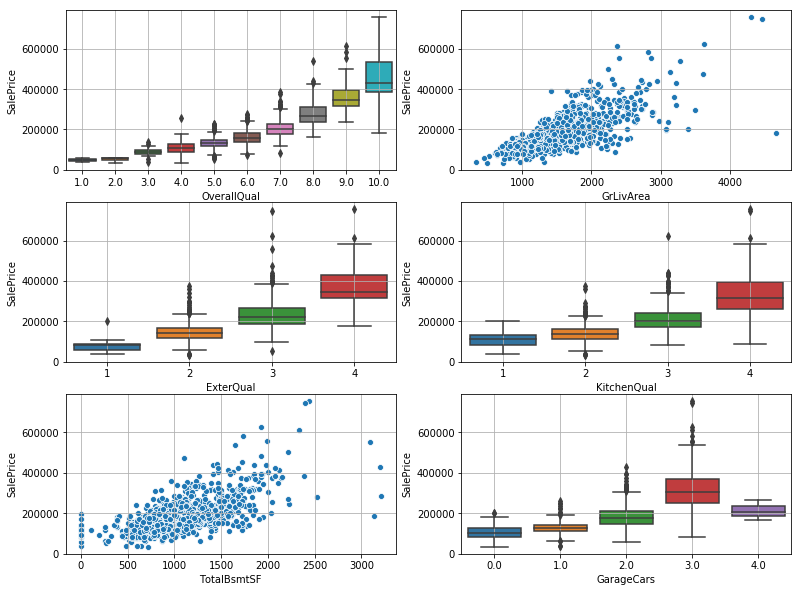

In [41]:
toPlot = correctedDF[['OverallQual','GrLivArea','ExterQual','KitchenQual','TotalBsmtSF','GarageCars','SalePrice']].copy()

plt.figure(figsize=(13,10))
plt.subplot(321)
sns.boxplot(data=correctedDF, x='OverallQual', y='SalePrice')
plt.grid()

plt.subplot(322)
sns.scatterplot(data=correctedDF, x='GrLivArea', y='SalePrice')
plt.grid()

plt.subplot(323)
sns.boxplot(data=correctedDF, x='ExterQual', y='SalePrice')
plt.grid()

plt.subplot(324)
sns.boxplot(data=correctedDF, x='KitchenQual', y='SalePrice')
plt.grid()

plt.subplot(325)
sns.scatterplot(data=correctedDF, x='TotalBsmtSF', y='SalePrice')
plt.grid()

plt.subplot(326)
sns.boxplot(data=correctedDF, x='GarageCars', y='SalePrice')
plt.grid()

Common for all the factors we are looking at here, is that the variance in SalePrice increases as each factor increases. With exception of GarageCars, which is unexpected. Here the mean, and deviation in SalePrice drops drasticly as GarageCars increases from three to four. We will inspect that more closely later. 

We may also have identified som outliers, particularily the single element which has GrLivArea > 4000 square feet, but a SalePrice below 200000 USD. In addition there are two elements with TotalBsmtSF > 3000 square feet and SalePrice < 300000 USD. 

In [49]:
pricesRawDF.groupby('GarageCars').count()['SalePrice']

GarageCars
0.0     67
1.0    303
2.0    680
3.0    147
4.0      3
Name: SalePrice, dtype: int64

Here we see that there are only three elements with GaraCars equal to 4, so that is probably the reason for the unexpected drop in the SalePrice.